In [2]:
%pip install tensorflow_hub tensorflow matplotlib sklearn imblearn pandas
#libraries used : pandas, matplotlib.py, sklearn, tensorflow, tensorflow_hub, imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


objective: trying to predict the score of a review given a text review.
This machine learning model uses a dataset containing all sorts of amazon reviews.
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information (, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("Reviews.csv")

In [5]:
#inspect a sample of the data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#drop unnecessary columns:
df.drop(["Id", "ProfileName", "UserId", "ProductId", "Time", "HelpfulnessNumerator", "HelpfulnessDenominator"], axis=1, inplace=True)

In [7]:
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#look for missing values:
df.isnull().values.any()
df.isnull().sum().sum()

27

In [9]:

#There are 26 missing values. Not too many so we can just delete the rows that contain them.

df.dropna(inplace=True)


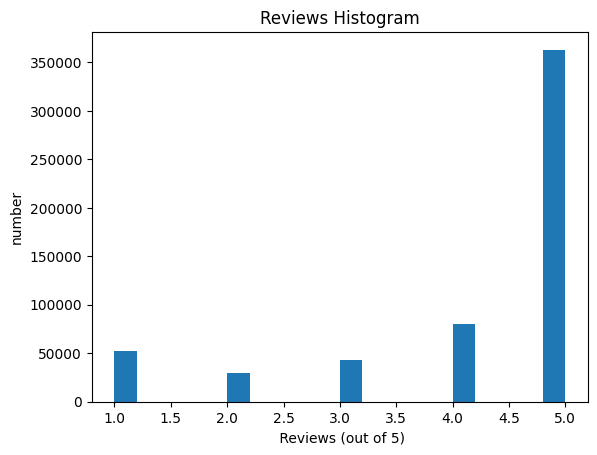

In [10]:
#plot a histogram to visualise the data (what the average review rating is)
import matplotlib.pyplot as plt

plt.hist(df.Score, bins=20)
plt.title("Reviews Histogram")
plt.ylabel("number")
plt.xlabel(" Reviews (out of 5)")
plt.show()

In [11]:
#can see that we have  a lot of positive reviews. Might have to oversample.
#creating a new model

df["good/bad review"] = (df.Score >= 4.0).astype(int)

df.head()

,Score,Summary,Text,good/bad review
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,2,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,Great taffy,Great taffy at a great price. There was a wid...,1


In [12]:
df = df[["Summary", "Text", "good/bad review"]]

In [13]:
df.head()

,Summary,Text,good/bad review
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,Cough Medicine,If you are looking for the secret ingredient i...,0
4,Great taffy,Great taffy at a great price. There was a wid...,1


we have more positive reviews than negative ones. So let's resample

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [26]:
train_data, temp = train_test_split(df, test_size=0.2, random_state=0)#80 training, 20 percent used for the validation and testing (held in e temporary variable)

#split the temporary data into testing and validation
valid_data, test_data = train_test_split(temp, test_size=0.5, random_state=0)

Using a pretrained embedding layer

In [27]:
import tensorflow_hub as hub
import tensorflow as tf

In [47]:
def df_to_dataset(data_df, shuffle=True, batch_size=10):
    df=data_df.copy()
    labels=df.pop("good/bad review")
    df = {key: value[:, tf.newaxis]for key, value in data_df.items()}
    data_set = tf.data.Dataset.from_tensor_slices((dict(df), labels))#create a tf data.dataset object with data and its labels
    if shuffle:
        data_set=data_set.shuffle(buffer_size=len(data_df))#shuffle data
    data_set = data_set.batch(batch_size) #split dataset into batches of 10 and repeat process for num of epochs
    data_set = data_set.prefetch(batch_size)
    return data_set

In [48]:
train= df_to_dataset(train_data)
valid= df_to_dataset(valid_data)
test= df_to_dataset(test_data)



C:\Users\amilc\AppData\Local\Temp\ipykernel_11528\3935711911.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis]for key, value in data_df.items()}
C:\Users\amilc\AppData\Local\Temp\ipykernel_11528\3935711911.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis]for key, value in data_df.items()}
C:\Users\amilc\AppData\Local\Temp\ipykernel_11528\3935711911.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis]for key, value in data_df.items()}


In [40]:
#building the model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"), #dense takes input from every preceding neuron
        #we have a layer of 16 neurons, activation is relu, so output 0 for every neg value and the value for every pos value
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"), #useful for binary classification as sigmoid maps our feature to a probability
])

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
             loss = tf.keras.losses.BinaryCrossentropy(), 
                metrics=["accuracy"])


In [32]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"  #Token based text embedding trained on English Google News 7B corpus.
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [34]:

#building the model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"), #dense takes input from every preceding neuron
        #we have a layer of 16 neurons, activation is relu, so output 0 for every neg value and the value for every pos value
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"), #useful for binary classification as sigmoid maps our feature to a probability
])



In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss = tf.keras.losses.BinaryCrossentropy(), #is binary classifer so use binarycross entropy
                metrics=["accuracy"])

In [36]:
#evaluating the model before training it
model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


UnimplementedError: Graph execution error:

Detected at node 'sequential_3/dense_9/Cast' defined at (most recent call last):
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\amilc\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\amilc\AppData\Local\Temp\ipykernel_11528\2116967932.py", line 2, in <module>
      model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid))
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\dense.py", line 181, in call
      inputs = tf.cast(inputs, dtype=self._compute_dtype_object)
Node: 'sequential_3/dense_9/Cast'
Cast string to float is not supported
	 [[{{node sequential_3/dense_9/Cast}}]] [Op:__inference_train_function_1923]